In [4]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
import torch
import torchvision.transforms as transforms
from scipy.optimize import linear_sum_assignment
import peft 
import random

In [5]:
ds = "data/Dataset"
# ds = f"military drones images"

models = f"/mnt/d/23b6034/FYP/models/DETR-4-peft"
train_dataset = f"/mnt/d/23b6034/FYP/datasets/{ds}/train"
test_dataset = f"/mnt/d/23b6034/FYP/datasets/{ds}/test"
val_dataset = f"/mnt/d/23b6034/FYP/datasets/{ds}/valid"

# Task
1. Load DETR
2. Freeze Both Base Layer and Transformer Layer
3. Train the head layer on our dataset

In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Then restart your kernel and re-run

seperator


In [7]:
# Set TORCH_HOME to your desired location
os.environ['TORCH_HOME'] = r'D:\23b6034\FYP\models'

# Now load the model
model2 = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=True)


Using cache found in D:\23b6034\FYP\models/hub/facebookresearch_detr_main
/mnt/d/23b6034/FYP/vengeance/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/d/23b6034/FYP/vengeance/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
tf_model = model2.transformer
print("Transformer model assigned to tf_model.")

Transformer model assigned to tf_model.


In [6]:
#Freeze the ResNet backbone
for param in model2.backbone.parameters():
    param.requires_grad = False

# Freeze the Transformer
for param in model2.transformer.parameters():
    param.requires_grad = False

print("ResNet and Transformer layers frozen.")

ResNet and Transformer layers frozen.


# Task
Fine-tune the head layers of a pre-trained DETR model for object detection on a custom dataset. The dataset consists of images in the "images" folder and corresponding label files in the "labels" folder. The classes are defined in the `classes` dictionary.

## Create a custom dataset class

### Subtask:
Define a PyTorch `Dataset` class to load your images from the `images` folder and parse the corresponding label files from the `labels` folder.


**Reasoning**:
Define a custom PyTorch Dataset class to load images and parse labels for the object detection task.



In [16]:
class DroneDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir, classes, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.classes = classes
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, os.path.splitext(img_name)[0] + '.txt') # Assuming label files have the same name as images with a .txt extension

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        boxes = []
        labels = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    class_id, center_x, center_y, width, height = map(float, line.strip().split())
                    # Convert YOLO format (center_x, center_y, width, height) to [x_min, y_min, x_max, y_max]
                    # Assuming coordinates are normalized (0 to 1)
                    x_min = center_x - width / 2
                    y_min = center_y - height / 2
                    x_max = center_x + width / 2
                    y_max = center_y + height / 2
                    boxes.append([x_min, y_min, x_max, y_max])
                    labels.append(int(class_id)) # Assuming class_id is an integer

        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)

        return image, target

## Create data loaders

### Subtask:
Instantiate `DataLoader` objects for the training, validation, and test datasets using the custom dataset class.


**Reasoning**:
Instantiate DataLoader objects for the training, validation, and test datasets using the custom dataset class.



In [10]:
classes = {
    0 : "-",
    1 : "BBM",
    2 : "BMP",
    3 : "BTR",
    4 :"CAY",
    5 : "MTLB",
    6 : "Shishiga", 
    7 : "buhanka",
    8 : "soldier",
    9: "tank",
    10 :"truck"
}

In [17]:
classes = {
    0 : "Tank",
    1 : "drone",
    2 : "people",
    3 : "soldier"
}
#tank drone people soldier

In [18]:
# Re-define the classes dictionary


# Define image and label directory paths
train_image_dir = train_dataset + "/images"
train_label_dir = train_dataset + "/labels"
val_image_dir = val_dataset + "/images"
val_label_dir = val_dataset + "/labels"
test_image_dir = test_dataset + "/images"
test_label_dir = test_dataset + "/labels"

# Define a suitable transform
# For DETR, a common transform resizes the image and normalizes it
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    # Add more transforms if needed, e.g., resizing to a fixed size expected by DETR
    # transforms.Resize((800, 800)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Instantiate the DroneDataset for each set
train_drone_dataset = DroneDataset(train_image_dir, train_label_dir, classes, transform=transform)
val_drone_dataset = DroneDataset(val_image_dir, val_label_dir, classes, transform=transform)
test_drone_dataset = DroneDataset(test_image_dir, test_label_dir, classes, transform=transform)


# Instantiate DataLoader objects for each dataset
batch_size = 1  # You can adjust this based on your GPU memory
# Added num_workers for parallel data loading
train_dataloader = DataLoader(train_drone_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)), num_workers=0)
val_dataloader = DataLoader(val_drone_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)), num_workers=0)
test_dataloader = DataLoader(test_drone_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)), num_workers=0)

print("DataLoaders for train, validation, and test datasets instantiated with num_workers.")

DataLoaders for train, validation, and test datasets instantiated with num_workers.


In [19]:
# Get the number of classes from your defined classes dictionary
num_classes = len(classes) # This will be 11 (0-10)

# Modify the classification head (class_embed) to match the number of classes in your dataset
# The input features should remain the same as the output features of the transformer decoder
model2.class_embed = torch.nn.Linear(model2.class_embed.in_features, num_classes)

# Move the modified model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2.to(device)

print(f"Model's classification head modified to output {model2.class_embed.out_features} classes.")

Model's classification head modified to output 4 classes.


In [14]:
print("new class head architecture:")
print(model2.class_embed)

new class head architecture:
Linear(in_features=256, out_features=4, bias=True)


**Reasoning**:
Define the loss function for object detection, which typically includes classification loss and bounding box regression loss.



In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2.to(device)

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment
import numpy as np


class DETRLoss(nn.Module):
    """
    DETR Loss Function with Hungarian Matching

    This loss computes the optimal bipartite matching between predicted and ground truth objects,
    and then computes classification and bounding box regression losses.
    """

    def __init__(self, num_classes, matcher_cost_class=1, matcher_cost_bbox=5,
                 matcher_cost_giou=2, loss_ce=2, loss_bbox=2.5, loss_giou=2,
                 eos_coef=0.1):
        """
        Parameters:
        - num_classes: number of object categories
        - matcher_cost_class: relative weight of classification error in matching cost
        - matcher_cost_bbox: relative weight of L1 error of bounding box coordinates in matching
        - matcher_cost_giou: relative weight of giou loss of bounding box in matching
        - loss_ce: relative weight of classification loss
        - loss_bbox: relative weight of L1 bounding box loss
        - loss_giou: relative weight of giou bounding box loss
        - eos_coef: relative classification weight applied to the no-object category
        """
        super().__init__()
        self.num_classes = num_classes
        self.matcher_cost_class = matcher_cost_class
        self.matcher_cost_bbox = matcher_cost_bbox
        self.matcher_cost_giou = matcher_cost_giou
        self.loss_ce = loss_ce
        self.loss_bbox = loss_bbox
        self.loss_giou = loss_giou
        self.eos_coef = eos_coef

        # Build weight vector for classification loss
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[-1] = self.eos_coef  # Background class
        self.register_buffer('empty_weight', empty_weight)

    def hungarian_matching(self, outputs, targets):
        batch_size, num_queries = outputs["pred_logits"].shape[:2]

        # Flatten to compute the cost matrices in a batch
        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes + 1]
        out_bbox = outputs["pred_boxes"].flatten(0, 1)  # [batch_size * num_queries, 4]

        # Concatenate all target labels and boxes
        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_bbox = torch.cat([v["boxes"] for v in targets])

        # Compute the classification cost
        cost_class = -out_prob[:, tgt_ids].log() # ------------------------------------------------------------ calculates the "how wrong the model's classification is" = measures confidence

        # Compute the L1 cost between boxes
        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1) # ---------------------------------------------------- calcs the "how wring the model's box location is compared to the ground truth" - Compute negative log-likelihood classification cost (higher for wrong predictions) = uses simple l1 distance, absolute difference between coordinates


        # Compute the GIoU cost between boxes
        cost_giou = -self.generalized_box_iou(
            self.box_cxcywh_to_xyxy(out_bbox),
            self.box_cxcywh_to_xyxy(tgt_bbox)
        ) # --------------------------------------------------------------------------------------------------- same as before, measures how wrong the box location is, but considering the spaces between the boxes - generalised intersction over union = gives sxore of -1 to +1

        # Final cost matrix
        C = (self.matcher_cost_bbox * cost_bbox +
             self.matcher_cost_class * cost_class +
             self.matcher_cost_giou * cost_giou)
        C = C.view(batch_size, num_queries, -1).cpu() # ------------------------------------------------------- combines all the three above costs into one single cost matrix

        sizes = [len(v["boxes"]) for v in targets]
        indices = []

        for i, c in enumerate(C.split(sizes, -1)):
            # Hungarian algorithm on the detached CPU tensor
            pred_indices, target_indices = linear_sum_assignment(c[i].detach().cpu().numpy()) # ---------------- looks at the entire cost matrix and finds the single best way to pair the predicted objects = weighted sum of three individual costs
            indices.append((torch.as_tensor(pred_indices, dtype=torch.int64),
                          torch.as_tensor(target_indices, dtype=torch.int64)))

        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64))
                for i, j in indices]

    def loss_labels(self, outputs, targets, indices):
        """Classification loss (Cross Entropy)"""
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                   dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = target_classes_o
        # Ensure target_classes is on the same device as src_logits
        target_classes = target_classes.to(src_logits.device)

        # Ensure empty_weight is on the same device as src_logits
        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight.to(src_logits.device))
        return loss_ce

    def loss_boxes(self, outputs, targets, indices):
        """Compute the losses related to the bounding boxes, the L1 regression loss and the GIoU loss"""
        assert 'pred_boxes' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')
        loss_bbox = loss_bbox.sum() / len(target_boxes) if len(target_boxes) > 0 else torch.tensor(0.0, device=src_boxes.device)

        loss_giou = 1 - torch.diag(self.generalized_box_iou(
            self.box_cxcywh_to_xyxy(src_boxes),
            self.box_cxcywh_to_xyxy(target_boxes)))
        loss_giou = loss_giou.sum() / len(target_boxes) if len(target_boxes) > 0 else torch.tensor(0.0, device=src_boxes.device)

        return loss_bbox, loss_giou

    def _get_src_permutation_idx(self, indices):
        """Permute predictions following indices"""
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def box_cxcywh_to_xyxy(self, x):
        """Convert boxes from (cx, cy, w, h) to (x1, y1, x2, y2) format"""
        x_c, y_c, w, h = x.unbind(-1)
        b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
             (x_c + 0.5 * w), (y_c + 0.5 * h)]
        return torch.stack(b, dim=-1)

    def generalized_box_iou(self, boxes1, boxes2): # -------------------------------------------------------------------------------------------------------- explain the intersection over union formula -
        """
        Generalized IoU from https://giou.stanford.edu/
        The boxes should be in [x0, y0, x1, y1] format
        """
        # Ensure boxes are valid
        assert (boxes1[:, 2:] >= boxes1[:, :2]).all()
        assert (boxes2[:, 2:] >= boxes2[:, :2]).all()

        # Compute intersection
        lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
        rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

        wh = (rb - lt).clamp(min=0)  # [N,M,2]
        inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

        # Compute union
        area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
        area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])
        union = area1[:, None] + area2 - inter

        # Compute IoU
        iou = inter / union

        # Compute the area of the smallest enclosing box
        lti = torch.min(boxes1[:, None, :2], boxes2[:, :2])
        rbi = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])

        whi = (rbi - lti).clamp(min=0)  # [N,M,2]
        areai = whi[:, :, 0] * whi[:, :, 1]

        return iou - (areai - union) / areai

    def forward(self, outputs, targets):
        """
        This performs the loss computation.

        Args:
            outputs: dict of tensors with keys:
                - pred_logits: Tensor of dim [batch_size, num_queries, num_classes + 1]
                - pred_boxes: Tensor of dim [batch_size, num_queries, 4] in cxcywh format
            targets: list of dicts, such that len(targets) == batch_size.
                Each dict should contain:
                - labels: Tensor of dim [num_objects] containing the class labels
                - boxes: Tensor of dim [num_objects, 4] containing the boxes in cx,cy,w,h format

        Returns:
            dict: A dictionary containing the losses
        """
        # Retrieve the matching between the outputs of the model and the targets
        indices = self.hungarian_matching(outputs, targets)

        # Compute all the losses
        loss_ce = self.loss_labels(outputs, targets, indices)
        loss_bbox, loss_giou = self.loss_boxes(outputs, targets, indices)

        # Combine losses
        losses = {
            'loss_ce': loss_ce * self.loss_ce,
            'loss_bbox': loss_bbox * self.loss_bbox,
            'loss_giou': loss_giou * self.loss_giou,
        }

        # Total loss
        losses['loss_total'] = sum(losses.values())

        return losses
# criterion = DETRLoss(model2.class_embed.out_features - 1) # really just 11 output dims
criterion = DETRLoss(
    num_classes=model2.class_embed.out_features - 1, # 11
    matcher_cost_class=1,
    matcher_cost_bbox=5,
    matcher_cost_giou=2,
    loss_ce=1,
    loss_bbox=5,
    loss_giou=2,
    eos_coef=0.1
)

Class HungarianMatcher:
  Function __init__(cost_class, cost_bbox, cost_giou):
    // Initialize with the weights for each cost component.
    // These weights determine the importance of each part of the cost matrix.
    self.cost_class = cost_class
    self.cost_bbox = cost_bbox
    self.cost_giou = cost_giou

    Function forward(predicted_outputs, ground_truth_targets):
  // Step 1: Get the number of predictions and ground truths
  num_queries = predicted_outputs.shape[0] // Number of predicted boxes
  num_targets = ground_truth_targets.shape[0] // Number of true boxes

  // Step 2: Compute the individual cost matrices
  cost_matrix_class = compute_class_cost(predicted_outputs.class_logits, ground_truth_targets.class_labels)
  cost_matrix_bbox = compute_bbox_cost(predicted_outputs.bbox_coords, ground_truth_targets.bbox_coords)
  cost_matrix_giou = compute_giou_cost(predicted_outputs.bbox_coords, ground_truth_targets.bbox_coords)

  // Step 3: Combine the costs into a single matrix
  total_cost_matrix = self.cost_class * cost_matrix_class + \
                      self.cost_bbox * cost_matrix_bbox + \
                      self.cost_giou * cost_matrix_giou

  // Step 4: Apply the Hungarian algorithm
  // This function finds the optimal one-to-one assignment
  // It returns two lists of indices: one for predictions, one for targets
  matched_indices_pred, matched_indices_target = solve_linear_sum_assignment(total_cost_matrix)

  // Step 5: Return the matched pairs as tuples
  return zip(matched_indices_pred, matched_indices_target)

  // Note: These helper functions would be separate or nested.
// The code below is a high-level view of what each one does.

Function compute_class_cost(predicted_logits, target_labels):
  // Calculate the negative log-likelihood of the predicted class for each target class.
  // This represents the cost of a misclassified match.
  Return a matrix of size (num_queries x num_targets).

Function compute_bbox_cost(predicted_bboxes, target_bboxes):
  // Calculate the L1 distance between each predicted bounding box and each target bounding box.
  // This measures the spatial difference.
  Return a matrix of size (num_queries x num_targets).

Function compute_giou_cost(predicted_bboxes, target_bboxes):
  // Calculate the Generalized Intersection over Union (GIoU) for each pair of boxes.
  // Subtract this from 1 to get a cost. A higher GIoU means a lower cost.
  Return a matrix of size (num_queries x num_targets).
  

In [22]:
print(torch.cuda.is_available())

True


In [23]:
from tqdm import tqdm
import torch
import os
import torch.optim as optim # Import the optim module

num_epochs = 300
# Move the model to the device (GPU if available)
model2.to(device)

# Define a directory to save checkpoints
checkpoint_dir = models
os.makedirs(checkpoint_dir, exist_ok=True) # just make the dir if not there

start_epoch = 0
optimizer = None  # Initialize optimizer to None

# Check for existing checkpoints to resume training
checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]
if checkpoints:
    print("Found existing checkpoints. Resuming training.")
    # Find the latest checkpoint
    latest_checkpoint = max([os.path.join(checkpoint_dir, f) for f in checkpoints], key=os.path.getctime) # ---- if folder has .pth file, use the one trained latest
    print(f"Loading checkpoint from: {latest_checkpoint}")
    model2.load_state_dict(torch.load(latest_checkpoint, map_location=torch.device('cpu'))) # ------------------ load the thing
    start_epoch = int(latest_checkpoint.split('_')[-1].split('.')[0]) # ---------------------------------------- set the epoch to the last trained epoch
    print(f"Resuming from epoch {start_epoch + 1}")

    optimizer = optim.AdamW(model2.parameters(), lr=1e-5)

else:
    print("No existing checkpoints found. Starting training from scratch.")
    optimizer = optim.AdamW(model2.parameters(), lr=1e-5)


No existing checkpoints found. Starting training from scratch.


In [27]:
print(model2)

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [39]:
# Add PEFT (LoRA) to your model
from peft import get_peft_model, LoraConfig, TaskType
import torch

# Example: wrap your model2 (DETR) with LoRA
lora_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,  # Change to TaskType appropriate for your model (e.g., TaskType.CAUSAL_LM, TaskType.SEQ_2_SEQ_LM, TaskType.TOKEN_CLASSIFICATION, etc.)
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    # You can adjust these parameters as needed
    target_modules = [
    "transformer.encoder.layers.0.self_attn",
    "transformer.encoder.layers.1.self_attn",
    "transformer.encoder.layers.2.self_attn",
    "transformer.encoder.layers.3.self_attn",
    "transformer.encoder.layers.4.self_attn",
    "transformer.encoder.layers.5.self_attn",
    "transformer.decoder.layers.0.self_attn",
    "transformer.decoder.layers.1.self_attn",
    "transformer.decoder.layers.2.self_attn",
    "transformer.decoder.layers.3.self_attn",
    "transformer.decoder.layers.4.self_attn",
    "transformer.decoder.layers.5.self_attn",
    "transformer.decoder.layers.0.multihead_attn",
    "transformer.decoder.layers.1.multihead_attn",
    "transformer.decoder.layers.2.multihead_attn",
    "transformer.decoder.layers.3.multihead_attn",
    "transformer.decoder.layers.4.multihead_attn",
    "transformer.decoder.layers.5.multihead_attn"
]  # Specify target modules if needed
    # modules_to_save=["classifier"]  # Optionally specify modules to save
    # ...other config options...
    )
peft_model = get_peft_model(model2, lora_config)
peft_model.print_trainable_parameters()

# Now use peft_model for training instead of model2

trainable params: 221,184 || all params: 41,723,336 || trainable%: 0.5301


In [18]:
#sanity check
# Print the architecture of the head layer (classification and box prediction heads)
print("Classification head architecture:")
print(model2.class_embed)

print("\nBox prediction head architecture:")
print(model2.bbox_embed)

Classification head architecture:
Linear(in_features=256, out_features=4, bias=True)

Box prediction head architecture:
MLP(
  (layers): ModuleList(
    (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=4, bias=True)
  )
)


In [40]:
from tqdm import tqdm
import torch
import os
torch.cuda.empty_cache()

#validation call

def validate_model(model, dataloader, loss_fn, device, checkpoint_dir):
    # Find the latest checkpoint
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]
    if not checkpoints:
        print("No checkpoints found in the specified directory.")
        return None # Or raise an error

    latest_checkpoint = max([os.path.join(checkpoint_dir, f) for f in checkpoints], key=os.path.getctime)
    print(f"Loading model from: {latest_checkpoint}")
    model.load_state_dict(torch.load(latest_checkpoint))

    model.eval() # Set the model to evaluation mode
    running_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation
        for images, targets in tqdm(dataloader, desc="Validation"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            # Use the correct loss function (DETRLoss)
            loss = loss_fn(outputs, targets)['loss_total']


            running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    return avg_loss

# Define the checkpoint directory
checkpoint_dir = models # Use the same directory as in training

# # Ensure the model is on the correct device before loading the state_dict
# model2.to(device)

# # Run validation
# # Make sure to use the correct loss function (DETRLoss)
# val_loss = validate_model(model2, val_dataloader, criterion, device, checkpoint_dir)
# if val_loss is not None:
#     print(f"Validation Loss: {val_loss:.4f}")

In [42]:
import os
import logging
from datetime import datetime

# Set up logging configuration
log_file = os.path.join(checkpoint_dir, 'log.txt')
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()  # This will still print to console
    ]
)
Danial = peft_model
# Log training start information
logging.info("="*50)
logging.info("TRAINING SESSION STARTED")
logging.info(f"Start epoch: {start_epoch}")
logging.info(f"Total epochs: {num_epochs}")
logging.info(f"Device: {device}")
logging.info("="*50)

for epoch in range(start_epoch, num_epochs): # start from the latest epoch and end with the end epoch(300)
    try: # -------------------------------------------------------------------------------------------------------------------------------------------------------------------- this is to handle errors
        logging.info(f"Starting Epoch {epoch+1}/{num_epochs}")
        
        Danial.train() # ------------------------------------------------------------------------------------------------------------------------------------------------------ puts the model into training mode
        running_loss = 0.0 # -------------------------------------------------------------------------------------------------------------------------------------------------- sets "cumulative loss" to 0
        batch_count = 0
        
        # Wrap the DataLoader with tqdm for a progress bar
        for images, targets in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Move images and targets to the device (GPU if available)
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = Danial(images)


            
            losses = criterion(outputs, targets) # Calculate total loss using detrloss
            loss = losses['loss_total']
           # print("---------------------------------------------------------------------------------------------------------------------------")
           #print(f"the loss is {loss}")
           # print("---------------------------------------------------------------------------------------------------------------------------")
           # print(f"the losses is {losses}") 
           # print("---------------------------------------------------------------------------------------------------------------------------")
           # print(f"the loss total is {losses['loss_total']}") 
           # print(f"with type {type(losses['loss_total'])}")
           # print(losses['loss_total'].requires_grad)

           # print("---------------------------------------------------------------------------------------------------------------------------")
           # print("---------------------------------------------------------------------------------------------------------------------------")
           # print("---------------------------------------------------------------------------------------------------------------------------")
            
            
            optimizer.zero_grad()
           # print("optimising done")
            loss.backward()
           # print("backwards done")
            optimizer.step()
           # print("stepping done")
            running_loss += loss.item()
            batch_count += 1
        
        # Calculate average training loss for this epoch
        avg_train_loss = running_loss / len(train_dataloader)
        
        # Log training results
        logging.info(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {avg_train_loss:.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")
        
        # Save the model checkpoint after each successful epoch
        checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth")
        torch.save(Danial.state_dict(), checkpoint_path)
        logging.info(f"Model checkpoint saved to {checkpoint_path}")
        print(f"Model saved to {checkpoint_path}")
        
        # Run validation and log results
        val_loss = validate_model(Danial, val_dataloader, criterion, device, checkpoint_dir)
        if val_loss is not None:
            logging.info(f"Epoch [{epoch+1}/{num_epochs}] - Validation Loss: {val_loss:.4f}")
            print(f"Validation Loss: {val_loss:.4f}")
        else:
            logging.warning(f"Epoch [{epoch+1}/{num_epochs}] - Validation returned None")
        
        # Log epoch completion
        logging.info(f"Epoch {epoch+1} completed successfully")
        logging.info("-" * 30)
        
    except Exception as e:
        error_msg = f"An error occurred during epoch {epoch+1}: {e}"
        logging.error(error_msg)
        print(error_msg)
        
        logging.info("Attempting to load the last saved checkpoint and stopping training.")
        print("Attempting to load the last saved checkpoint and stopping training.")
        
        # Find the last saved checkpoint before the error occurred
        checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]
        if checkpoints:
            last_checkpoint = max([os.path.join(checkpoint_dir, f) for f in checkpoints], key=os.path.getctime)
            logging.info(f"Loading checkpoint from: {last_checkpoint}")
            print(f"Loading checkpoint from: {last_checkpoint}")
            try:
                Danial.load_state_dict(torch.load(last_checkpoint))
                logging.info("Successfully loaded last checkpoint.")
                print("Successfully loaded last checkpoint.")
            except Exception as load_error:
                error_msg = f"Error loading checkpoint: {load_error}"
                logging.error(error_msg)
                print(error_msg)
        else:
            logging.warning("No checkpoints found to load.")
            print("No checkpoints found to load.")
        
        logging.info("Training stopped due to error.")
        break # Stop the training loop after encountering an error

# Log training completion
logging.info("="*50)
logging.info("TRAINING SESSION ENDED")
logging.info(f"Final epoch reached: {epoch+1}")
logging.info("="*50)

# After training (or interruption), move the model back to CPU if needed for inference or saving
# model2.to('cpu')
# check epoch 27 and 74

2025-09-19 17:16:25,755 - INFO - ==================================================
2025-09-19 17:16:25,756 - INFO - TRAINING SESSION STARTED
2025-09-19 17:16:25,758 - INFO - Start epoch: 0
2025-09-19 17:16:25,759 - INFO - Total epochs: 300
2025-09-19 17:16:25,760 - INFO - Device: cuda
2025-09-19 17:16:25,761 - INFO - ==================================================
2025-09-19 17:16:25,781 - INFO - Starting Epoch 1/300
Epoch 1/300:   0%|          | 0/5591 [00:00<?, ?it/s]

Epoch 1/300:   0%|          | 0/5591 [00:00<?, ?it/s]
2025-09-19 17:16:25,910 - ERROR - An error occurred during epoch 1: DETR.forward() got an unexpected keyword argument 'input_ids'
2025-09-19 17:16:25,911 - INFO - Attempting to load the last saved checkpoint and stopping training.
2025-09-19 17:16:25,914 - WARNING - No checkpoints found to load.
2025-09-19 17:16:25,915 - INFO - Training stopped due to error.
2025-09-19 17:16:25,916 - INFO - ==================================================
2025-09-19 17:16:25,917 - INFO - TRAINING SESSION ENDED
2025-09-19 17:16:25,918 - INFO - Final epoch reached: 1
2025-09-19 17:16:25,919 - INFO - ==================================================


An error occurred during epoch 1: DETR.forward() got an unexpected keyword argument 'input_ids'
Attempting to load the last saved checkpoint and stopping training.
No checkpoints found to load.


In [51]:
import torch
import os
from collections import OrderedDict

def print_model_info(model, checkpoint_dir=None, model_name="Model"):
    """
    Print comprehensive information about the model architecture
    
    Args:
        model: The PyTorch model
        checkpoint_dir: Directory containing checkpoints (optional)
        model_name: Name to display for the model
    """
    print("="*80)
    print(f"{model_name.upper()} ARCHITECTURE INFORMATION")
    print("="*80)
    
    # Load latest checkpoint if directory provided
    if checkpoint_dir and os.path.exists(checkpoint_dir):
        checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]
        if checkpoints:
            latest_checkpoint = max([os.path.join(checkpoint_dir, f) for f in checkpoints], 
                                  key=os.path.getctime)
            print(f"Loading weights from: {latest_checkpoint}")
            model.load_state_dict(torch.load(latest_checkpoint, map_location='cpu'))
            print()
    
    # 1. Model Summary
    print("1. MODEL SUMMARY")
    print("-" * 40)
    print(f"Model Type: {type(model).__name__}")
    print(f"Model Class: {model.__class__.__module__}.{model.__class__.__name__}")
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Non-trainable Parameters: {non_trainable_params:,}")
    print(f"Model Size (MB): {total_params * 4 / (1024**2):.2f}")  # Assuming float32
    print()
    
    # 2. Layer-wise Information
    print("2. LAYER-WISE INFORMATION")
    print("-" * 40)
    print(f"{'Layer Name':<40} {'Type':<25} {'Parameters':<15} {'Trainable'}")
    print("-" * 90)
    
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # Only leaf modules
            param_count = sum(p.numel() for p in module.parameters())
            trainable = any(p.requires_grad for p in module.parameters())
            module_type = type(module).__name__
            
            # Truncate long names
            display_name = name if len(name) <= 39 else name[:36] + "..."
            
            print(f"{display_name:<40} {module_type:<25} {param_count:<15,} {'Yes' if trainable else 'No'}")
    print()
    
    # 3. Parameter Details by Layer Type
    print("3. PARAMETERS BY LAYER TYPE")
    print("-" * 40)
    layer_stats = {}
    
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # Only leaf modules
            module_type = type(module).__name__
            param_count = sum(p.numel() for p in module.parameters())
            
            if module_type in layer_stats:
                layer_stats[module_type]['count'] += 1
                layer_stats[module_type]['params'] += param_count
            else:
                layer_stats[module_type] = {'count': 1, 'params': param_count}
    
    for layer_type, stats in sorted(layer_stats.items()):
        print(f"{layer_type:<30} Count: {stats['count']:<5} Parameters: {stats['params']:,}")
    print()
    
    # 4. Model Architecture Structure
    print("4. MODEL ARCHITECTURE STRUCTURE")
    print("-" * 40)
    print(model)
    print()
    
    # 5. Device Information
    print("5. DEVICE INFORMATION")
    print("-" * 40)
    try:
        # Check if model parameters are on GPU or CPU
        first_param = next(model.parameters())
        print(f"Model Device: {first_param.device}")
        print(f"Model Data Type: {first_param.dtype}")
    except StopIteration:
        print("No parameters found in the model")
    print()
    
    # 6. Additional Model Properties (for specific models like DETR)
    print("6. ADDITIONAL MODEL PROPERTIES")
    print("-" * 40)
    
    # Check for common attributes
    attributes_to_check = [
        'num_classes', 'hidden_dim', 'nheads', 'num_encoder_layers', 
        'num_decoder_layers', 'dim_feedforward', 'backbone', 'num_queries'
    ]
    
    for attr in attributes_to_check:
        if hasattr(model, attr):
            value = getattr(model, attr)
            print(f"{attr}: {value}")
    
    # For DETR models, check backbone info
    if hasattr(model, 'backbone'):
        print(f"Backbone type: {type(model.backbone).__name__}")
    
    print("="*80)

# Usage example:
def display_model_architecture(model, checkpoint_dir=None):
    """
    Wrapper function to display model architecture information
    """
    print_model_info(model, checkpoint_dir, "DETR Model")

# Example usage with your variables:
checkpoint_dir = "D:/23b6034-emerging-tech/FYP/models/DETR"
display_model_architecture(model2, checkpoint_dir)

DETR MODEL ARCHITECTURE INFORMATION
1. MODEL SUMMARY
----------------------------------------
Model Type: DETR
Model Class: models.detr.DETR
Total Parameters: 41,503,951
Trainable Parameters: 41,281,551
Non-trainable Parameters: 222,400
Model Size (MB): 158.33

2. LAYER-WISE INFORMATION
----------------------------------------
Layer Name                               Type                      Parameters      Trainable
------------------------------------------------------------------------------------------
transformer.encoder.layers.0.self_at...  NonDynamicallyQuantizableLinear 65,792          Yes
transformer.encoder.layers.0.linear1     Linear                    526,336         Yes
transformer.encoder.layers.0.dropout     Dropout                   0               No
transformer.encoder.layers.0.linear2     Linear                    524,544         Yes
transformer.encoder.layers.0.norm1       LayerNorm                 512             Yes
transformer.encoder.layers.0.norm2       LayerN

Loaded image from: D:/23b6034/FYP/datasets/Military objects in military environments/Dataset/test/images\509_png_jpg.rf.bc354cf42dbbfbd3f1bb110aaa5089e0.jpg
Image transformed, batch dimension added, and moved to device.
Loading model from: D:/23b6034/FYP/models/DETR-4\model_epoch_163.pth
Model loaded successfully.
Inference complete. Outputs obtained.
Predicted Object: soldier


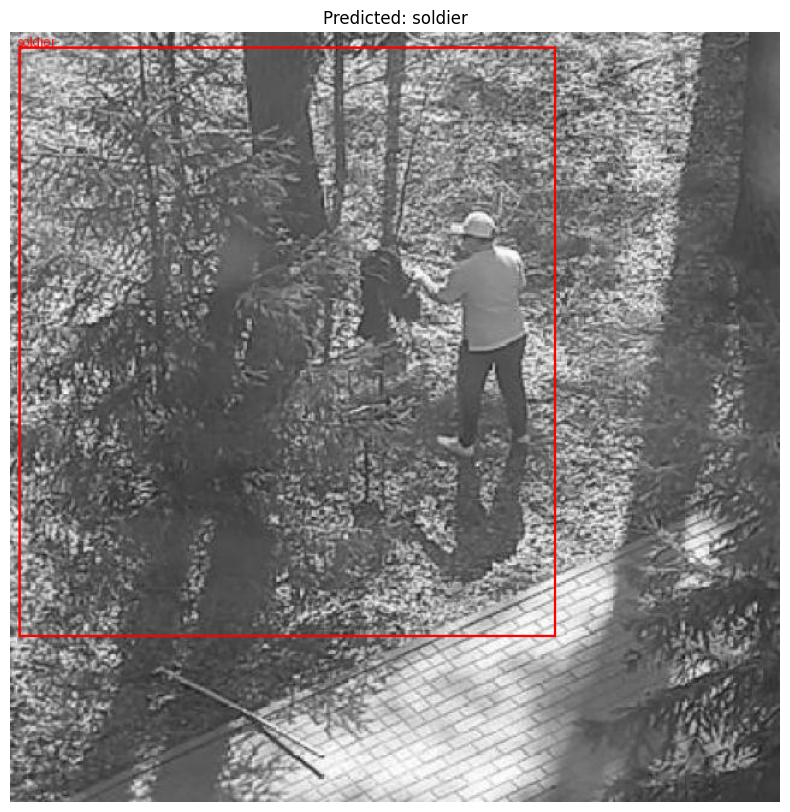

In [31]:
import random
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose a specific image file path from the test dataset directory
test_image_filename = test_drone_dataset.image_filenames[random.randint(0,200)] # Load the first image in the test set
test_image_path = os.path.join(test_image_dir, test_image_filename)

# Load the image using PIL
image = Image.open(test_image_path).convert("RGB")

print(f"Loaded image from: {test_image_path}")

# Apply the same transform used during training
transform = transforms.Compose([
    #transforms.Resize((320, 320)),
    transforms.ToTensor(),
    # Add more transforms if needed, e.g., resizing to a fixed size expected by DETR
    # transforms.Resize((800, 800)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transformed_image = transform(image)

# Add a batch dimension (model expects input in batches)
transformed_image = transformed_image.unsqueeze(0)

# Move the preprocessed image to the device
transformed_image = transformed_image.to(device)

print("Image transformed, batch dimension added, and moved to device.")


# Define the checkpoint directory (same as in training)
checkpoint_dir = models

# Find the latest checkpoint
checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]
if not checkpoints:
    print("No checkpoints found in the specified directory.")
else:
    latest_checkpoint = max([os.path.join(checkpoint_dir, f) for f in checkpoints], key=os.path.getctime)
    print(f"Loading model from: {latest_checkpoint}")
    model2.load_state_dict(torch.load(latest_checkpoint))
    print("Model loaded successfully.")


model2.eval() # Set the model to evaluation mode
with torch.no_grad(): # Disable gradient calculation
    outputs = model2(transformed_image)

print("Inference complete. Outputs obtained.")

import torch.nn.functional as F

# Get the predicted class probabilities and bounding boxes for the first image
prob = F.softmax(outputs['pred_logits'][0], dim=-1)
boxes = outputs['pred_boxes'][0]

# Filter predictions based on a confidence threshold
confidence_threshold = 0.9
keep = prob.max(-1).values > confidence_threshold

# Apply the filter
prob_filtered = prob[keep]
boxes_filtered = boxes[keep]

# Get the predicted class labels for the filtered predictions
labels_filtered = prob_filtered.argmax(-1)

# Find the index of the prediction with the highest confidence score
if len(prob_filtered) > 0:
    max_confidence_index = prob_filtered.max(-1).values.argmax()
    # Select the best box and label
    best_box = boxes_filtered[max_confidence_index].unsqueeze(0) # Keep it as a batch of 1 for consistent processing
    best_label = labels_filtered[max_confidence_index].unsqueeze(0)

    # Convert normalized bounding boxes to [x_min, y_min, x_max, y_max] format
    img_width, img_height = image.size

    boxes_converted = torch.stack([
        best_box[:, 0] - best_box[:, 2] / 2,
        best_box[:, 1] - best_box[:, 3] / 2,
        best_box[:, 0] + best_box[:, 2] / 2,
        best_box[:, 1] + best_box[:, 3] / 2,
    ], dim=-1)

    # Scale the bounding boxes to the original image dimensions
    boxes_scaled = boxes_converted * torch.tensor([img_width, img_height, img_width, img_height], device=device)

    # Get class name and class number
    class_number = best_label.item()
    class_name = classes.get(class_number, "Unknown")

    # Print the predicted object
    print(f"Predicted Object: {class_name}")

    # Draw bounding box on the image using Pillow
    draw = ImageDraw.Draw(image)
    # Convert the box to integer coordinates for drawing
    box_int = [int(coord) for coord in boxes_scaled[0].tolist()]
    draw.rectangle(box_int, outline="red", width=2)

    # Add text label
    try:
        # Adjust text position if the box is too close to the top edge
        text_x = box_int[0]
        text_y = box_int[1] - 10 if box_int[1] > 10 else box_int[3] + 5 # Position above or below the box

        # Try to use a default font if available, otherwise skip text drawing
        try:
            font = ImageFont.load_default()
        except ImportError:
            print("Warning: Could not load default font. Text labels will not be drawn.")
            font = None

        if font:
             draw.text((text_x, text_y), class_name, fill="red", font=font)
    except Exception as e:
        print(f"Error drawing text: {e}")


    # Display the image with matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off') # Hide axes
    plt.title(f"Predicted: {class_name}")
    plt.show()

else:
    print("No predictions found above the confidence threshold.")

Parsing training log...
Found 294 training records
Epochs: 14 to 300
Loss range: 1.5179 to 2.0789


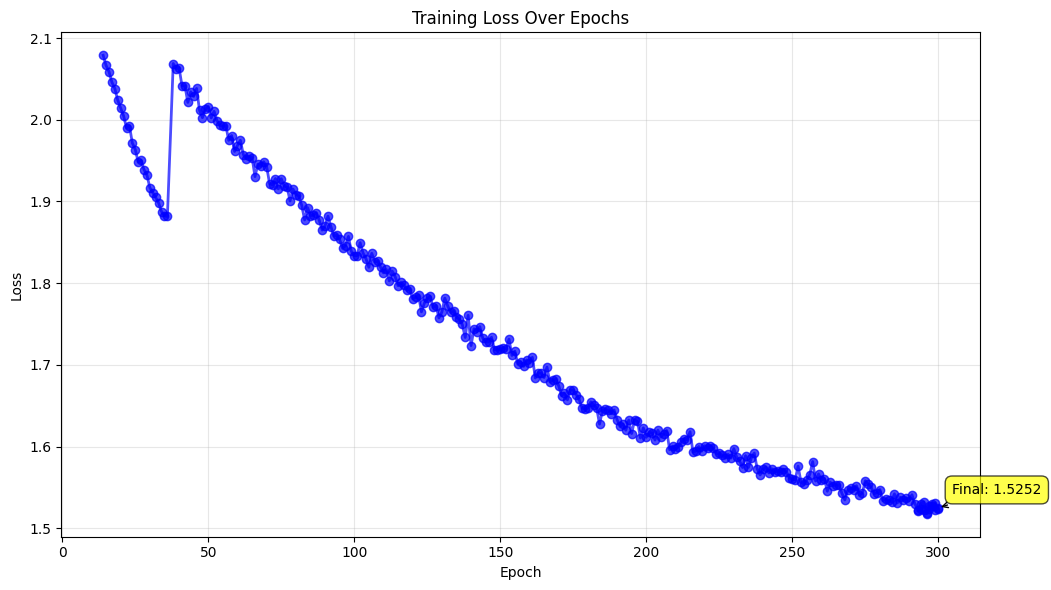

In [22]:
import re
import matplotlib.pyplot as plt
from datetime import datetime

def parse_training_log(filename):
    """
    Parse training log file and extract epoch, loss, and timestamp data.
    
    Args:
        filename (str): Path to the log file
        
    Returns:
        tuple: (epochs, losses, timestamps)
    """
    epochs = []
    losses = []
    timestamps = []
    
    # Regular expression pattern to match the log format
    pattern = r"=== Training Completed at (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})\s+with loss ([\d.]+)\s+for epoch (\d+) ==="
    
    try:
        with open(filename, 'r') as file:
            for line in file:
                line = line.strip()
                match = re.match(pattern, line)
                if match:
                    timestamp_str, loss_str, epoch_str = match.groups()
                    
                    # Parse timestamp
                    timestamp = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S')
                    timestamps.append(timestamp)
                    
                    # Parse loss and epoch
                    loss = float(loss_str)
                    epoch = int(epoch_str)
                    
                    losses.append(loss)
                    epochs.append(epoch)
                    
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return [], [], []
    except Exception as e:
        print(f"Error reading file: {e}")
        return [], [], []
    
    return epochs, losses, timestamps

def plot_loss_over_epochs(epochs, losses, timestamps=None):
    """
    Create a loss over epochs plot.
    
    Args:
        epochs (list): List of epoch numbers
        losses (list): List of corresponding loss values
        timestamps (list, optional): List of timestamps for additional info
    """
    if not epochs or not losses:
        print("No data to plot.")
        return
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, losses, 'b-o', linewidth=2, markersize=6, alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True, alpha=0.3)
    
    # Add some styling
    plt.tight_layout()
    
    # Annotate the final loss value
    if epochs and losses:
        final_epoch = epochs[-1]
        final_loss = losses[-1]
        plt.annotate(f'Final: {final_loss:.4f}', 
                    xy=(final_epoch, final_loss), 
                    xytext=(10, 10), 
                    textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    plt.show()

def main():
    """Main function to run the log parser and create the plot."""
    log_filename = 'log.txt'  # Change this to your log file path
    
    print("Parsing training log...")
    epochs, losses, timestamps = parse_training_log(log_filename)
    
    if epochs:
        print(f"Found {len(epochs)} training records")
        print(f"Epochs: {min(epochs)} to {max(epochs)}")
        print(f"Loss range: {min(losses):.4f} to {max(losses):.4f}")
        
        # Create the plot
        plot_loss_over_epochs(epochs, losses, timestamps)
        
        # Optionally, print the data
        # print("\nParsed data:")
        # for i, (epoch, loss, timestamp) in enumerate(zip(epochs, losses, timestamps)):
        #     print(f"Epoch {epoch}: Loss {loss:.4f} at {timestamp}")
    else:
        print("No training data found in the log file.")

if __name__ == "__main__":
    main()

In [27]:
# Performance Metrics for Object Detection (DETR)
# This cell computes mAP, precision, recall, F1 score, and per-class AP using torchmetrics

import torch
import numpy as np
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from collections import defaultdict

# Initialize the metric
map_metric = MeanAveragePrecision(iou_type="bbox", class_metrics=True)

def evaluate_model_metrics(model, dataloader, device, classes, confidence_threshold=0.5):
    model.eval()
    all_outputs = []
    all_targets = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)
            # Convert outputs to torchmetrics format
            batch_preds = []
            batch_targets = []
            for i in range(len(images)):
                # Predictions
                pred_logits = outputs['pred_logits'][i]
                pred_boxes = outputs['pred_boxes'][i]
                scores, labels = torch.max(torch.softmax(pred_logits, dim=-1), dim=-1)
                keep = scores > confidence_threshold
                batch_preds.append({
                    'boxes': pred_boxes[keep].detach().cpu(),
                    'scores': scores[keep].detach().cpu(),
                    'labels': labels[keep].detach().cpu()
                })
                # Ground truth
                batch_targets.append({
                    'boxes': targets[i]['boxes'].detach().cpu(),
                    'labels': targets[i]['labels'].detach().cpu()
                })
            all_outputs.extend(batch_preds)
            all_targets.extend(batch_targets)
    # Compute metrics
    map_metric.reset()
    map_metric.update(all_outputs, all_targets)
    results = map_metric.compute()
    print("\n--- Detection Metrics ---")
    print(f"mAP@0.5: {results['map_50']:.4f}")
    print(f"mAP@0.5:0.95: {results['map']:.4f}")
    # print(f"Precision: {results['precision']:.4f}")
    # print(f"Recall: {results['recall']:.4f}")
    # print(f"F1 Score: {results['f1']:.4f}")
    print("Per-class AP:")
    for i, ap in enumerate(results['map_per_class']):
        class_name = classes.get(i, str(i))
        print(f"  {class_name}: {ap:.4f}")
    return results

# Example usage:
metrics = evaluate_model_metrics(model2, test_dataloader, device, classes, confidence_threshold=0.5)
# You can also run on val_dataloader for validation metrics


--- Detection Metrics ---
mAP@0.5: 0.3999
mAP@0.5:0.95: 0.2021
Per-class AP:
  Tank: 0.1900
  drone: 0.1506
  people: 0.4674
  soldier: 0.0003


In [24]:
# Custom Precision, Recall, F1 Score for Object Detection
# This cell computes precision, recall, and F1 score using IoU matching

import torch
import numpy as np

def compute_prf1(pred_boxes, pred_labels, gt_boxes, gt_labels, iou_threshold=0.5):
    """
    Compute precision, recall, and F1 score for a single image.
    Args:
        pred_boxes: [N_pred, 4] predicted boxes
        pred_labels: [N_pred] predicted labels
        gt_boxes: [N_gt, 4] ground truth boxes
        gt_labels: [N_gt] ground truth labels
        iou_threshold: IoU threshold for a match
    Returns:
        tp, fp, fn: true positives, false positives, false negatives
    """
    def iou(boxA, boxB):
        # Compute IoU between two boxes
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        interArea = max(0, xB - xA) * max(0, yB - yA)
        boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
        boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
        iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
        return iou
    
    matched_gt = set()
    tp = 0
    fp = 0
    for i, p_box in enumerate(pred_boxes):
        p_label = pred_labels[i]
        found_match = False
        for j, g_box in enumerate(gt_boxes):
            if j in matched_gt:
                continue
            if p_label == gt_labels[j] and iou(p_box, g_box) >= iou_threshold:
                tp += 1
                matched_gt.add(j)
                found_match = True
                break
        if not found_match:
            fp += 1
    fn = len(gt_boxes) - len(matched_gt)
    return tp, fp, fn

def evaluate_precision_recall_f1(model, dataloader, device, classes, confidence_threshold=0.5, iou_threshold=0.5):
    model.eval()
    total_tp = 0
    total_fp = 0
    total_fn = 0
    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)
            for i in range(len(images)):
                pred_logits = outputs['pred_logits'][i]
                pred_boxes = outputs['pred_boxes'][i]
                scores, labels = torch.max(torch.softmax(pred_logits, dim=-1), dim=-1)
                keep = scores > confidence_threshold
                pred_boxes = pred_boxes[keep].detach().cpu().numpy()
                pred_labels = labels[keep].detach().cpu().numpy()
                gt_boxes = targets[i]['boxes'].detach().cpu().numpy()
                gt_labels = targets[i]['labels'].detach().cpu().numpy()
                # Convert boxes from cxcywh to xyxy
                def cxcywh_to_xyxy(boxes):
                    x_c, y_c, w, h = np.split(boxes, 4, axis=1)
                    x_min = x_c - w / 2
                    y_min = y_c - h / 2
                    x_max = x_c + w / 2
                    y_max = y_c + h / 2
                    return np.concatenate([x_min, y_min, x_max, y_max], axis=1)
                pred_boxes = cxcywh_to_xyxy(pred_boxes)
                gt_boxes = cxcywh_to_xyxy(gt_boxes)
                tp, fp, fn = compute_prf1(pred_boxes, pred_labels, gt_boxes, gt_labels, iou_threshold)
                total_tp += tp
                total_fp += fp
                total_fn += fn
    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall = total_tp / (total_tp + total_fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    print("\n--- Custom Precision/Recall/F1 ---")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    return precision, recall, f1

# Example usage:
precision, recall, f1 = evaluate_precision_recall_f1(model2, test_dataloader, device, classes, confidence_threshold=0.5, iou_threshold=0.5)


--- Custom Precision/Recall/F1 ---
Precision: 0.0116
Recall: 0.7396
F1 Score: 0.0229
